In [1]:
import numpy as np
import pickle
import os
import time
from matplotlib import pyplot as plt

In [2]:
from keras.models import load_model

Using TensorFlow backend.
/home/mbazulin/miniconda3/envs/my_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mbazulin/miniconda3/envs/my_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mbazulin/miniconda3/envs/my_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mbazu

In [3]:
train_output_folder = './train_output/'

In [4]:
# fonts
import matplotlib
font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : 16}
matplotlib.rc('font', **font)

In [5]:
# load lists
with open('list_dataset_filepaths', 'rb') as fp:
    list_dataset_filepaths = pickle.load(fp) # list of the paths to samples form the dataset
with open('list_parameters', 'rb') as fp:
    list_parameters= pickle.load(fp) # list of parameters (neural network output)
# load coefficient shot gather (input) normalization
with open('max_seism_value', 'rb') as fp:
    max_seism_value = pickle.load(fp) # this parameter is used for the input dataset normalization

In [6]:
datset_size = len(list_dataset_filepaths)
assert len(list_dataset_filepaths) == len(list_parameters)
print('datset size:', datset_size)

datset size: 400


In [7]:
#reading block
# function for the dataset reading from file 
filename_r_time = './dataset/seism_time.bin' # each sample (shot gather) has the same time size, which is saved in this file
time_full = np.fromfile (filename_r_time)
mean_timestep = len (time_full)

num_of_rec_in_group = 21
epoch_number = 0 # the value changes during training process
def read_x_data(list_dataset_filepaths):
    np.random.seed()
    global epoch_number, time_full, mean_timestep
    seismogram = np.zeros((len(list_dataset_filepaths), num_of_rec_in_group, mean_timestep))
#     amp_map = np.zeros((num_of_rec_in_group, mean_timestep)) # amplitude map (moving average) fot noise adding
#     N = 220 # width of the window usded for the amplitude map calculation
#     gain = np.exp(-4e5*time_full[:]**2)*1e2/(epoch_number+1)+1
    gain = np.exp(-4e5*time_full[:]**2)*5e1
    gain /= max_seism_value
    for ifile, file_path in enumerate(list_dataset_filepaths):
        filename_r = file_path
        seism_read = np.fromfile(filename_r)
        for irec in range(num_of_rec_in_group):
            seismogram[ifile, irec, :] = seism_read[irec*mean_timestep:(irec+1)*mean_timestep]*gain
#             amp_map[irec, :] = np.convolve(abs(seismogram[ifile, irec, :]), np.ones((N))/N, mode='same')
#         noise = np.random.rand(num_of_rec_in_group, mean_timestep)/5-0.1
#         seismogram[ifile, :, :] = seismogram[ifile, :, :] + noise*amp_map[:,:]
        if seismogram.shape[1]*seismogram.shape[2]*8 != os.path.getsize(filename_r):
            print('error! smth wrong with reading')
    return seismogram.reshape(seismogram.shape[0], seismogram.shape[1],seismogram.shape[2], 1) #channels last

In [8]:
# funtion used for the Keras fit_generator
def dataset_loader(list_dataset_filepaths, list_parameters, batch_size):
    L=len(list_dataset_filepaths)
    #this line is just to make the generator infinite, keras needs that
    while True:
        batch_start = 0
        batch_end = batch_size
        while batch_start < L:
            limit = min(batch_end, L)
            x_dataset = read_x_data(list_dataset_filepaths[batch_start:limit])
            y_dataset = np.array(list_parameters[batch_start:limit])
            batch_start += batch_size
            batch_end += batch_size
            yield (x_dataset, y_dataset) #a tuple with two numpy arrays with batch_size samples

In [9]:
# check shapes of the x and y dataset
# y dataset is needed here only for checking
x_dataset_example = read_x_data(list_dataset_filepaths[9:10])
y_dataset_example = np.array(list_parameters[9:10])
print ('x_dataset shape (batch(=1), num_of_rec_in_group, timesteps, channels(=1)):', x_dataset_example.shape)
print ('y_dataset shape (batch(=1), dim[vp ,vs]):', y_dataset_example.shape)

x_dataset shape (batch(=1), num_of_rec_in_group, timesteps, channels(=1)): (1, 21, 5500, 1)
y_dataset shape (batch(=1), dim[vp ,vs]): (1, 6)


In [10]:
model = load_model(train_output_folder + 'model.h5')
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 21, 5500, 50)      1850      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 5500, 50)      62550     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 5500, 50)      62550     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 2750, 50)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 2750, 75)      33825     
_________________________________________________________________
conv2d_5 (Conv2D)    

/home/mbazulin/miniconda3/envs/my_env/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [11]:
batch_size = 8
predictions = model.predict_generator(dataset_loader(list_dataset_filepaths, list_parameters, batch_size), steps=np.ceil(len(list_dataset_filepaths)/batch_size), verbose=1)

50/50 [==============================] - 5s 109ms/step


In [12]:
# from normalization_param_list.txt
rho_max=3839.0
vp_max=6489.0
vs_max=3999.0
eps_max=0.25956490635871887
gamma_max=0.24065768718719482
delta_max=0.2931036949157715
rho_mean=0.6626886129379272
vp_mean=0.6760891079902649
vs_mean=0.7519354820251465
eps_mean=0.30609753727912903
gamma_mean=0.19618447124958038
delta_mean=0.2660829424858093

In [13]:
# convert predictions to real values
# take these coef from normilize_log_file.ipynb
for i in range(len(predictions)):
    #unMEAN
    predictions[i][0] += rho_mean
    predictions[i][1] += vp_mean
    predictions[i][2] += vs_mean
    predictions[i][3] += eps_mean
    predictions[i][4] += gamma_mean
    predictions[i][5] += delta_mean
    #unMAX
    predictions[i][0] *= rho_max
    predictions[i][1] *= vp_max
    predictions[i][2] *= vs_max
    predictions[i][3] *= eps_max
    predictions[i][4] *= gamma_max
    predictions[i][5] *= delta_max

In [14]:
# print('pred:', predictions[0])
# print('true:', list_parameters[0])
list_parameters = np.array(list_parameters)
predictions = np.array(predictions)

In [15]:
# def find_bad_points(arr1, arr2):
#     arr_bad = abs(arr1-arr2)/arr2
#     arr_bad_idx = np.where(arr_bad>0.09)
#     arr_bad = arr_bad[arr_bad_idx]
#     return arr_bad_idx

# bad_eps_idx = find_bad_points(list_parameters[:,3], predictions[:,3])
# print(len(bad_eps_idx[0]))

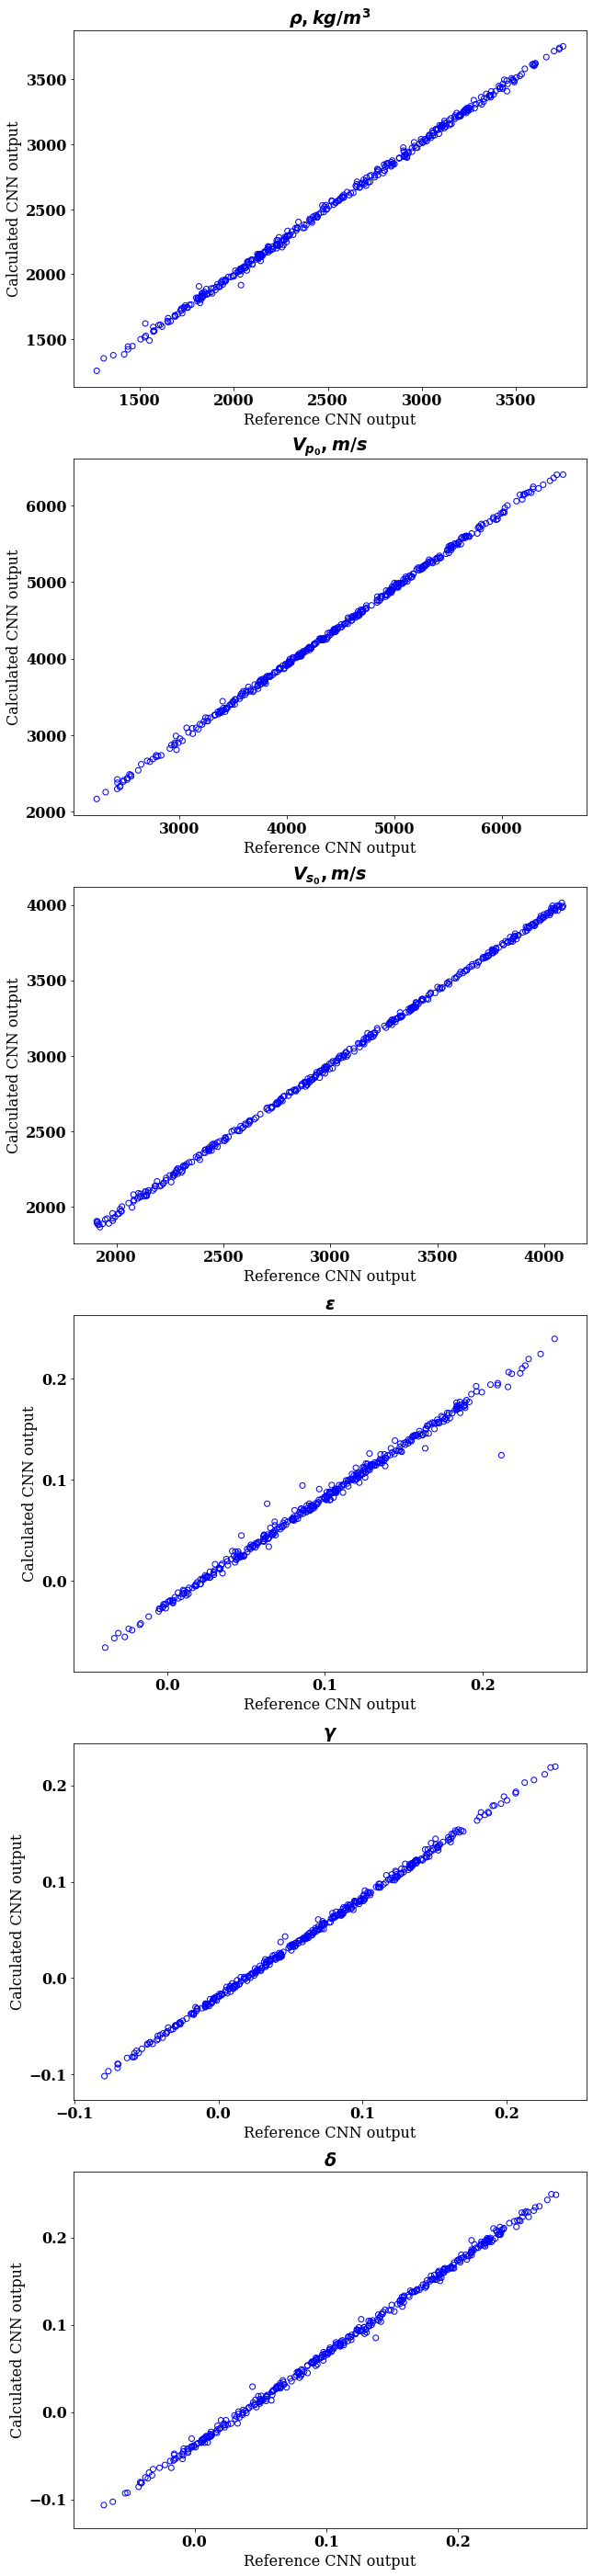

In [16]:
#one_png
fig_res, ax_res = plt.subplots(6,1)
fig_res.set_size_inches(10, 50)
ax_res[0].set(xlabel='Reference CNN output', ylabel= 'Calculated CNN output', title=r'$\rho, kg/m^3$')
ax_res[0].scatter(list_parameters[:,0], predictions[:,0], facecolors='none', edgecolors='b')
ax_res[0].locator_params(nbins=6)
ax_res[1].set(xlabel='Reference CNN output', ylabel= 'Calculated CNN output', title=r'$V_{p_0}, m/s$')
ax_res[1].scatter(list_parameters[:,1], predictions[:,1], facecolors='none', edgecolors='b')
ax_res[1].locator_params(nbins=6)
ax_res[2].set(xlabel='Reference CNN output', ylabel= 'Calculated CNN output', title=r'$V_{s_0}, m/s$')
ax_res[2].scatter(list_parameters[:,2], predictions[:,2], facecolors='none', edgecolors='b')
ax_res[2].locator_params(nbins=6)
ax_res[3].set(xlabel='Reference CNN output', ylabel= 'Calculated CNN output', title=r'$\varepsilon$')
ax_res[3].scatter(list_parameters[:,3], predictions[:,3], facecolors='none', edgecolors='b')
ax_res[3].locator_params(nbins=6)
ax_res[4].set(xlabel='Reference CNN output', ylabel= 'Calculated CNN output', title=r'$\gamma$')
ax_res[4].scatter(list_parameters[:,4], predictions[:,4], facecolors='none', edgecolors='b')
ax_res[4].locator_params(nbins=6)
ax_res[5].set(xlabel='Reference CNN output', ylabel= 'Calculated CNN output', title=r'$\delta$')
ax_res[5].scatter(list_parameters[:,5], predictions[:,5], facecolors='none', edgecolors='b')
ax_res[5].locator_params(nbins=6)

# ax_res[0].scatter(list_parameters[bad_eps_idx,0], predictions[bad_eps_idx,0], facecolors='r', edgecolors='r')
# ax_res[1].scatter(list_parameters[bad_eps_idx,1], predictions[bad_eps_idx,1], facecolors='r', edgecolors='r')
# ax_res[2].scatter(list_parameters[bad_eps_idx,2], predictions[bad_eps_idx,2], facecolors='r', edgecolors='r')
# ax_res[3].scatter(list_parameters[bad_eps_idx,3], predictions[bad_eps_idx,3], facecolors='r', edgecolors='r')
# ax_res[4].scatter(list_parameters[bad_eps_idx,4], predictions[bad_eps_idx,4], facecolors='r', edgecolors='r')
# ax_res[5].scatter(list_parameters[bad_eps_idx,5], predictions[bad_eps_idx,5], facecolors='r', edgecolors='r')